In [1]:
import json
import re
import bz2
import regex
from tqdm import tqdm
from scipy import sparse
from collections import Counter
from pymystem3 import Mystem
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:16, 1470.34it/s]


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
    * существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

0: Создадим датафрейм

In [5]:
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [6]:
df.describe(include='all')

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
count,138325,153499,153499,153499.000000,153498,153479,153499,153499,153499,88658.000000
unique,5823,1,122941,NaN,670,104519,670,147616,153429,NaN
top,г. Москва,False,,NaN,лицензия № 1481,Complince,Сбербанк России,2014-10-16 15:07:00,"Здравствуйте, я являюсь руководителем организа...",NaN
freq,55354,153499,1223,NaN,26327,181,26327,4,6,NaN
mean,NaN,NaN,NaN,3.722102,NaN,NaN,NaN,NaN,NaN,2.153274
std,NaN,NaN,NaN,6.695089,NaN,NaN,NaN,NaN,NaN,1.509953
min,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,3.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


1: Посчитайте количество отзывов в разных городах и на разные банки

In [8]:
df.city.value_counts()[:10]

г. Москва             55354
г. Санкт-Петербург    14342
г. Екатеринбург        2337
г. Новосибирск         2300
г. Нижний Новгород     1976
г. Ростов-на-Дону      1891
г. Самара              1731
г. Челябинск           1507
г. Казань              1440
г. Краснодар           1262
Name: city, dtype: int64

In [9]:
df.bank_name.value_counts()[:10]

Сбербанк России              26327
Альфа-Банк                   10224
ВТБ 24                        8185
Русский Стандарт              7943
Хоум Кредит Банк              7549
Тинькофф Банк                 5387
Национальный Банк «Траст»     4607
Ренессанс Кредит              3849
Связной Банк                  3775
ОТП Банк                      3237
Name: bank_name, dtype: int64

2: Постройте гистограмы длин слов в символах и в словах

In [10]:
w_c=[]
c_c=[]
for item in df.text:
    w_c.append(len(item.split()))
    c_c.append(len(item))
df['word_count']=w_c
df['char_count']=c_c

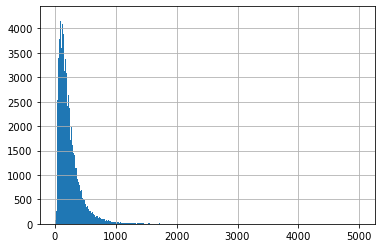

In [11]:
df['word_count'].hist(bins='auto')

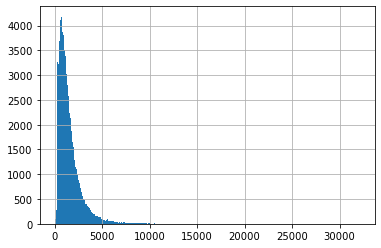

In [12]:
df['char_count'].hist(bins='auto')

3: Найдите 10 самых частых:
слов
слов без стоп-слов
лемм
существительных

In [13]:
def words_only(text, regex=re.compile("[А-Яа-я]+")):
    return " ".join(regex.findall(text))

mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""


m = Mystem()
def lemmatize_(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "


morph=MorphAnalyzer()
def noun_strip(text):
    try:
        return " ".join([item if morph.parse(item)[0].tag.POS=='NOUN' else " " for item in text.split()])
    except:
        return " "


def most_common(text):
    words_list = [word for text_ in text for word in text_.split()]
    cnt=Counter(words_list)
    return cnt.most_common(10)


def text_prep(text):
    text1 = words_only(text)
    text2 = remove_stopwords(text1)
    return lemmatize_(text2)

In [14]:
%%time
words1 = df.text.str.lower()
words1 = words1.apply(words_only)
words1

CPU times: user 12.8 s, sys: 373 ms, total: 13.2 s
Wall time: 13.3 s


0         добрый день я не являюсь клиентом банка и пору...
1         доброго дня являюсь держателем зарплатной карт...
2         здравствуйте дублирую свое заявление от в до м...
3         добрый день я открыл расчетный счет в сбербанк...
4         г взяла кредит в вашем банке заявленная мною с...
                                ...                        
153494    слишком большой банк не всегда учитывает нашу ...
153495    вы сами виноваты в своих проблемах кроме предп...
153496    уважаемое руководство банка овк я проживаю в г...
153497    пробовала оформить товар в кредит в альфа банк...
153498    если коротко то мне нравится кридит получать м...
Name: text, Length: 153499, dtype: object

In [15]:
%%time
words2 = words1.apply(remove_stopwords)
words2

CPU times: user 53.9 s, sys: 237 ms, total: 54.1 s
Wall time: 54.4 s


0         добрый день являюсь клиентом банка поручителем...
1         доброго дня являюсь держателем зарплатной карт...
2         здравствуйте дублирую свое заявление можайский...
3         добрый день открыл расчетный счет сбербанке юр...
4         г взяла кредит вашем банке заявленная мною сум...
                                ...                        
153494    слишком большой банк учитывает нашу специфику ...
153495    сами виноваты своих проблемах кроме предпослед...
153496    уважаемое руководство банка овк проживаю г ива...
153497    пробовала оформить товар кредит альфа банке ко...
153498    коротко нравится кридит получать милое дело ан...
Name: text, Length: 153499, dtype: object

In [16]:
%%time
words3 = words2.apply(lemmatize_)
words3

CPU times: user 1min 43s, sys: 7.99 s, total: 1min 51s
Wall time: 19min 21s


0         добрый день являться клиент банк поручитель кр...
1         добрый день являться держатель зарплатной карт...
2         здравствовать дублировать свой заявление можай...
3         добрый день открывать расчетный счет сбербанк ...
4         г взять кредит ваш банк заявлять я сумма рубль...
                                ...                        
153494    слишком большой банк учитывать наш специфика п...
153495    сам виноватый свой проблема кроме предпоследни...
153496    уважать руководство банк овк проживать г ивано...
153497    пробовать оформлять товар кредит альфа банк ко...
153498    короче нравиться кридит получать милый дело ан...
Name: text, Length: 153499, dtype: object

In [17]:
%%time
words4 = words3.apply(noun_strip)
words4

CPU times: user 59min 8s, sys: 12 s, total: 59min 20s
Wall time: 59min 35s


0           день   клиент банк поручитель   договор     ...
1           день   держатель   карта   сбербанк россия г...
2               заявление         карта   покупка интерн...
3           день     счет сбербанк юр лицо   договор   к...
4         г   кредит   банк     сумма рубль год менеджер...
                                ...                        
153494        банк     специфика продукт   карта     пол...
153495          проблема     сообщение   срыв ресторан  ...
153496      руководство банк     г иваново   филиал   ба...
153497        товар кредит альфа банк   центр     оформл...
153498              дело анкета интернет   звонок скроки...
Name: text, Length: 153499, dtype: object

In [18]:
most_common(words1)

[('в', 1330550),
 ('и', 1058997),
 ('не', 855335),
 ('на', 707935),
 ('что', 640057),
 ('я', 577500),
 ('с', 464037),
 ('по', 372769),
 ('мне', 320958),
 ('банка', 275906)]

In [19]:
most_common(words2)

[('банка', 275906),
 ('банк', 215426),
 ('деньги', 131201),
 ('карту', 105829),
 ('карты', 101821),
 ('кредит', 81136),
 ('день', 76552),
 ('банке', 72169),
 ('заявление', 70423),
 ('очень', 66824)]

In [20]:
most_common(words3)

[('банк', 623032),
 ('карта', 334999),
 ('деньги', 179734),
 ('день', 173043),
 ('мой', 163042),
 ('кредит', 156177),
 ('который', 148986),
 ('отделение', 144050),
 ('клиент', 136892),
 ('сотрудник', 134168)]

In [21]:
most_common(words4)

[('банк', 623032),
 ('карта', 334999),
 ('деньги', 179734),
 ('день', 173043),
 ('кредит', 156177),
 ('отделение', 144050),
 ('клиент', 136892),
 ('сотрудник', 134168),
 ('счет', 126894),
 ('сумма', 111232)]

4: Постройте кривые Ципфа и Хипса

Кривая Ципфа (втречаемость слова обратно пропорциональна его порядку)

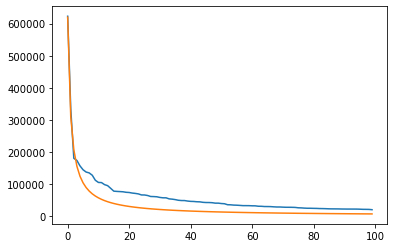

In [22]:
words_ = [word for text_ in words4 for word in text_.split()]
cnt=Counter(words_)
plt.plot(sort(list(cnt.values()))[::-1][:100])
plt.plot([620000/x for x in range(1,101)])

Кривая Хипса (количество разных слов в тексте пропорционально его длине)

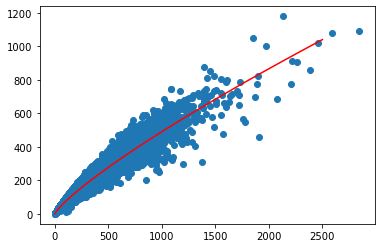

In [23]:
plt.scatter(x=[len(text.split()) for text in words3], y=[len(Counter(text.split())) for text in words3])
plt.plot([1.7*x**0.82 for x in range(1,2502)], c='r')

5: Ответьте на следующие вопросы:
- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?

In [24]:
most_common(words4)

[('банк', 623032),
 ('карта', 334999),
 ('деньги', 179734),
 ('день', 173043),
 ('кредит', 156177),
 ('отделение', 144050),
 ('клиент', 136892),
 ('сотрудник', 134168),
 ('счет', 126894),
 ('сумма', 111232)]

'Клиент' встречается чаще.

In [25]:
cnt=Counter([word for text_ in words4 for word in text_.split()])
print('Мошенничество:',cnt.get('мошенничество'))
print('Доверие:',cnt.get('доверие'))

Мошенничество: 3244
Доверие: 2108


В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру  𝑡𝑓−𝑖𝑑𝑓 , для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [26]:
pos=df[df.rating_grade==5]
neg=df[df.rating_grade==1]

In [27]:
%%time
pos3 = pos.text.apply(text_prep)

CPU times: user 16.9 s, sys: 764 ms, total: 17.7 s
Wall time: 2min 4s


In [28]:
%%time
neg3 = neg.text.apply(text_prep)

CPU times: user 1min 8s, sys: 2.95 s, total: 1min 11s
Wall time: 8min 11s


In [29]:
tfidf_pos = TfidfVectorizer(max_df=0.85,max_features=10000,ngram_range=(1,2))
tfidf_pos_m = tfidf_pos.fit_transform(list(pos3))
list(tfidf_pos.vocabulary_.keys())[:50]

['досрочно',
 'закрывать',
 'вклад',
 'отпуск',
 'жена',
 'заказывать',
 'заранее',
 'забывать',
 'сотрудник',
 'спб',
 'наталья',
 'отказывать',
 'хотя',
 'сумма',
 'значительный',
 'работать',
 'быстро',
 'профессионально',
 'ничто',
 'лишний',
 'жаль',
 'прием',
 'офис',
 'доступность',
 'замечать',
 'нести',
 'деньги',
 'брать',
 'кредит',
 'желать',
 'успех',
 'банка',
 'досрочно закрывать',
 'закрывать вклад',
 'заказывать заранее',
 'сотрудник банк',
 'работать быстро',
 'быстро профессионально',
 'вклад офис',
 'деньги вклад',
 'брать кредит',
 'желать успех',
 'хотеть',
 'открывать',
 'доходный',
 'год',
 'процент',
 'начисляться',
 'месяц',
 'но']

In [30]:
tfidf_neg = TfidfVectorizer(max_df=0.85,max_features=10000,ngram_range=(1,2))
tfidf_neg_m = tfidf_neg.fit_transform(list(neg3))
list(tfidf_neg.vocabulary_.keys())[:50]

['открывать',
 'вклад',
 'счет',
 'плюс',
 'этот',
 'зарплатный',
 'карта',
 'рубль',
 'сам',
 'себя',
 'сегодня',
 'приходить',
 'указанный',
 'отделение',
 'цель',
 'пополнять',
 'долларовый',
 'сч',
 'давать',
 'операционист',
 'паспорт',
 'окошко',
 'написать',
 'подтверждение',
 'операция',
 'подобный',
 'прошлый',
 'потребовать',
 'сказать',
 'нужно',
 'полагать',
 'деньги',
 'вс',
 'взять',
 'делать',
 'крутить',
 'вставлять',
 'терминал',
 'вводить',
 'пин',
 'получать',
 'ответ',
 'чек',
 'доллар',
 'вносить',
 'вопрос',
 'банка',
 'понимать',
 'кто',
 'сознательно']

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [31]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaModel, lsimodel
from gensim import similarities
import pyLDAvis
import pyLDAvis.gensim

In [32]:
texts = [text.split() for text in words4]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [33]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

Попробуем по 5 тем с LSI, LDA.

In [34]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)
lda = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)

CPU times: user 3min 12s, sys: 2.92 s, total: 3min 15s
Wall time: 2min 51s


In [35]:
lsi.show_topics()

[(0,
  '0.273*"карта" + 0.178*"кредит" + 0.159*"деньги" + 0.149*"заявление" + 0.148*"счет" + 0.141*"банкомат" + 0.140*"вклад" + 0.137*"отделение" + 0.133*"сбербанк" + 0.132*"сумма"'),
 (1,
  '-0.793*"вклад" + -0.154*"очередь" + 0.139*"кредит" + 0.117*"карта" + 0.113*"платеж" + -0.110*"процент" + 0.107*"сбербанк" + -0.104*"офис" + -0.100*"вкладчик" + 0.098*"заявление"'),
 (2,
  '-0.465*"кредит" + 0.355*"карта" + 0.300*"банкомат" + -0.255*"страховка" + 0.196*"сбербанк" + -0.189*"договор" + -0.153*"погашение" + 0.147*"операция" + -0.142*"платеж" + 0.140*"деньги"'),
 (3,
  '0.276*"заявка" + 0.251*"номер" + -0.241*"платеж" + -0.239*"сумма" + -0.221*"руб" + 0.213*"звонок" + -0.170*"банкомат" + -0.169*"рубль" + -0.168*"счет" + 0.159*"телефон"'),
 (4,
  '0.409*"номер" + -0.330*"страховка" + 0.317*"звонок" + -0.250*"карта" + -0.189*"заявка" + 0.184*"телефон" + 0.179*"кошелек" + -0.170*"страхование" + 0.146*"вклад" + 0.142*"база"')]

Скоре всего, первая тема связана с всевозможными опциями взаимодействия с банком: открытие вкладов, счетов, получение кредитов.
Четвертая категория связана с телефонными операциями.

In [36]:
lda.show_topics()

[(0,
  '0.016*"кредит" + 0.010*"задолженность" + 0.008*"долг" + 0.008*"платеж" + 0.008*"штраф" + 0.007*"просрочка" + 0.006*"договор" + 0.006*"письмо" + 0.006*"звонок" + 0.006*"погашение"'),
 (1,
  '0.008*"кредит" + 0.008*"карта" + 0.006*"отделение" + 0.006*"очередь" + 0.006*"документ" + 0.005*"минута" + 0.005*"офис" + 0.005*"клиент" + 0.005*"девушка" + 0.005*"заявка"'),
 (2,
  '0.054*"админ" + 0.009*"дельта" + 0.009*"здание" + 0.007*"этаж" + 0.006*"ашан" + 0.006*"сестра" + 0.006*"возрождение" + 0.005*"студент" + 0.005*"брат" + 0.005*"хам"'),
 (3,
  '0.020*"банкомат" + 0.014*"карта" + 0.012*"деньги" + 0.010*"счет" + 0.009*"заявление" + 0.008*"претензия" + 0.007*"операция" + 0.007*"платеж" + 0.006*"сумма" + 0.006*"ситибанк"'),
 (4,
  '0.021*"вклад" + 0.010*"процент" + 0.008*"депозит" + 0.007*"карта" + 0.007*"комиссия" + 0.007*"евро" + 0.007*"доллар" + 0.006*"обслуживание" + 0.006*"лимит" + 0.006*"счет"')]

Первая категория связана, скорее всего с мошенническими темами.
Вторая - с опытом взаимодействия с отделениями банков.
Третья - с кредитами.

In [37]:
%%time
lsi10 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)
lda10 = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)

CPU times: user 3min 7s, sys: 2.99 s, total: 3min 10s
Wall time: 2min 45s


In [38]:
lsi10.show_topics()

[(0,
  '0.273*"карта" + 0.178*"кредит" + 0.160*"деньги" + 0.148*"заявление" + 0.148*"счет" + 0.143*"банкомат" + 0.140*"вклад" + 0.137*"отделение" + 0.132*"сбербанк" + 0.132*"сумма"'),
 (1,
  '-0.792*"вклад" + -0.143*"очередь" + 0.138*"карта" + 0.135*"банкомат" + 0.117*"сбербанк" + -0.116*"процент" + 0.110*"платеж" + -0.103*"офис" + -0.101*"ставка" + -0.099*"вкладчик"'),
 (2,
  '-0.464*"кредит" + 0.362*"банкомат" + 0.310*"карта" + -0.223*"страховка" + -0.179*"договор" + 0.172*"сбербанк" + 0.161*"деньги" + -0.157*"платеж" + -0.154*"погашение" + 0.149*"операция"'),
 (3,
  '-0.361*"банкомат" + 0.284*"заявка" + 0.276*"карта" + -0.232*"сумма" + -0.203*"платеж" + -0.195*"руб" + -0.178*"деньги" + 0.170*"номер" + -0.157*"рубль" + -0.153*"погашение"'),
 (4,
  '0.449*"банкомат" + -0.395*"карта" + 0.181*"очередь" + -0.172*"лимит" + -0.162*"комиссия" + -0.143*"руб" + 0.139*"номер" + 0.139*"купюра" + 0.133*"человек" + -0.118*"счет"'),
 (5,
  '0.360*"номер" + -0.356*"страховка" + 0.240*"звонок" + -0.

Зачастую в темах одновременно присутствуют вместе с у понминанием сбербанка слова: банкомат, карта, страховка, вклад. Возможно, это были основные проблемные места в отзывах.

In [39]:
lda10.show_topics()

[(0,
  '0.059*"сити" + 0.048*"ситифон" + 0.040*"юниаструм" + 0.017*"эксперт" + 0.015*"пробизнесбанк" + 0.015*"райфа" + 0.015*"мальчик" + 0.014*"физик" + 0.012*"уралсиб" + 0.012*"физлицо"'),
 (1,
  '0.016*"вклад" + 0.010*"очередь" + 0.009*"отделение" + 0.007*"минута" + 0.007*"офис" + 0.007*"касса" + 0.007*"обслуживание" + 0.007*"клиент" + 0.007*"карта" + 0.006*"деньги"'),
 (2,
  '0.028*"авангард" + 0.014*"электрон" + 0.010*"грейс" + 0.009*"извещение" + 0.009*"сервер" + 0.009*"возрождение" + 0.008*"получас" + 0.008*"мини" + 0.007*"загранпаспорт" + 0.007*"заправка"'),
 (3,
  '0.022*"обменник" + 0.016*"купюра" + 0.012*"обналичка" + 0.011*"мыло" + 0.009*"квартал" + 0.009*"курсы" + 0.009*"лидер" + 0.009*"недочет" + 0.008*"станция" + 0.007*"холл"'),
 (4,
  '0.007*"кредит" + 0.005*"телефон" + 0.005*"звонок" + 0.005*"сотрудник" + 0.005*"человек" + 0.004*"письмо" + 0.004*"документ" + 0.004*"отдел" + 0.004*"договор" + 0.004*"номер"'),
 (5,
  '0.021*"карта" + 0.016*"банкомат" + 0.010*"деньги" + 0.

In [40]:
pyLDAvis.enable_notebook()

In [41]:
vis = pyLDAvis.gensim.prepare(lda10, corpus_tfidf, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.293863  0.007565       1        1  26.912264
5      0.280406  0.019565       2        1  26.481005
4      0.198050 -0.019130       3        1  14.603920
6      0.211301 -0.016565       4        1  10.794222
7      0.190919  0.037180       5        1   8.569017
2     -0.177208 -0.162417       6        1   2.883006
9     -0.232727 -0.065456       7        1   2.709091
0     -0.258007  0.231164       8        1   2.425634
8     -0.259494 -0.018105       9        1   2.355378
3     -0.247103 -0.013801      10        1   2.266459, topic_info=           Term         Freq        Total Category  logprob  loglift
3817      админ  2582.000000  2582.000000  Default  30.0000  30.0000
4167       сити  1486.000000  1486.000000  Default  29.0000  29.0000
25       кредит  5326.000000  5326.000000  Default  28.0000  28.0000
4934    ситифон   907.000000   907.000000  Default  27.0000  27.0000
334       вклад  3484.000000  3484.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1232     купюра   284.910400  1016.035522  Topic10  -4.1223   2.5155
3280  сберкасса   116.246651   214.088013  Topic10  -5.0188   3.1763
1233      пачка   120.648758   256.116608  Topic10  -4.9816   3.0342
2305   быстрота    71.063904   157.515915  Topic10  -5.5109   2.9910
1745       чека    68.736084   276.005981  Topic10  -5.5442   2.3968

[624 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2993      7  0.997122       аба
5196      5  0.997770   абсолют
938       3  0.227073  авангард
938       5  0.195232  авангард
938       6  0.525368  авангард
...     ...       ...       ...
6032      1  0.989526    юрлица
2923      8  0.988765   явление
6801      2  0.988893  якиманка
1115      5  0.984806    ячейка
1115      8  0.011724    ячейка

[1409 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 5, 7, 8, 3, 10, 1, 9, 4])

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [ ]:


# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])
